## Usage

1. 해당 분류의 img path를 img_root에 넣는다.
2. 몇 개의 class만 확인하고 싶은 경우 classes에 확인 하고 싶은 소분류 class를 넣는다.
3. imgs에 너무 많은 image가 들어간 경우 random.choices(imgs, k=?)로 대충 sampling해서 돌린다.
4. batch size는 16이상으로 지정하는 것이 좋다.
5. epoch은 20~30만해도 될 것 같다.

In [1]:
import os
from os.path import splitext, join
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm

img_root = '/opt/ml/data/final-project-level3-cv-17/classification/new_data/valid/dumpling'
# label_root = r'/opt/ml/data/labels/train'

# for img_path in os.listdir(img_root):
#     imgs.append(join(img_root, img_path))

classes = [
    '02012001',
    '02012002',
    '02012003'
]

imgs = []
labels = []

# -- label data 2 dataframe & xywh 2 xyxy
df = pd.DataFrame([], columns=['class', 'mean1', 'mean2', 'mean3', 'std1', 'std2', 'std3'])

num = 100
img_dirs = os.listdir(img_root)
for img_dir in tqdm(img_dirs):
    for img_file in os.listdir(join(img_root, img_dir))[:num]:
        filename = splitext(img_file)[0]

        small_label = filename.split('_')[2]
        labels.append(int(small_label))
        imgs.append(np.array(Image.open(join(img_root, img_dir, img_file))))

100%|██████████| 5/5 [00:00<00:00,  6.45it/s]


In [2]:
print(len(imgs))
print(len(labels))
num_classes = len(np.unique(labels))
print(num_classes)

500
500
5


In [3]:
import torch
import random
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.transforms import *

class TripletDataset(Dataset):
    def __init__(self, img_paths, labels, train=True):
        self.img_paths = np.array(img_paths)
        self.labels = np.array(labels)
        self.transform = transforms.Compose([
            ToTensor(),
            Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2)),
        ])
        self.train = train

    def __getitem__(self, idx: torch.Tensor) -> torch.Tensor:
        anchor_img, anchor_label = self.img_paths[idx], self.labels[idx]
        if self.transform:
            anchor_img = self.transform(anchor_img)

        if self.train:
            positive_idx = np.where(self.labels == anchor_label)[0]
            positive_idx = [p_idx for p_idx in positive_idx if p_idx != idx] # anchor index 제외
            negative_idx = np.where(self.labels != anchor_label)[0]

            positive_img = self.img_paths[random.choice(positive_idx)]
            negative_img = self.img_paths[random.choice(negative_idx)]

            if self.transform:
                positive_img = self.transform(positive_img)
                negative_img = self.transform(negative_img)
            
            return anchor_img, positive_img, negative_img, anchor_label

        return anchor_img, anchor_label

    def __len__(self):
        return len(self.labels)

In [4]:
import torch
import torch.nn as nn


class TripletLoss(nn.Module):
    '''
    Compute normal triplet loss or soft margin triplet loss given triplets
    '''
    def __init__(self, margin = None):
        super(TripletLoss, self).__init__()
        self.margin = margin
        if self.margin is None:  # use soft-margin
            self.Loss = nn.SoftMarginLoss()
        else:
            self.Loss = nn.TripletMarginLoss(margin = margin, p = 2)

    def forward(self, anchor, pos, neg):
        if self.margin is None:
            num_samples = anchor.shape[0]
            y = torch.ones((num_samples, 1)).view(-1)
            if anchor.is_cuda: y = y.cuda()
            ap_dist = torch.norm(anchor - pos, 2, dim = 1).view(-1)
            an_dist = torch.norm(anchor - neg, 2, dim = 1).view(-1)
            loss = self.Loss(an_dist - ap_dist, y)
        else:
            loss = self.Loss(anchor, pos, neg)

        return loss

In [5]:
from torch.utils.data import DataLoader
from efficientnet_pytorch import EfficientNet
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import multiprocessing
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
train_set = TripletDataset(imgs, labels)
dataloader = DataLoader(train_set,
                        batch_size=16,
                        num_workers=multiprocessing.cpu_count()//2,
                        shuffle=False,
                        pin_memory=use_cuda)
model = EfficientNet.from_pretrained('efficientnet-b3', num_classes=num_classes)
optimizer = optim.SGD(
    params=model.parameters(),
    lr=0.01,
    momentum=0.9,
    weight_decay=1e-5
)
# optimizer = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-4)
criterion = TripletLoss(margin=1.0)
NUM_EPOCH = 50

cuda
Loaded pretrained weights for efficientnet-b3


In [6]:
model = model.to(device)

for epoch in range(NUM_EPOCH):
    losses = []
    
    model.train()
    for idx, (anchor_img, positive_img, negative_img, anchor_label) in enumerate(tqdm(dataloader)):
        anchor_img = anchor_img.to(device)
        positive_img = positive_img.to(device)
        negative_img = negative_img.to(device)
        anchor_label = anchor_label.to(device)

        optimizer.zero_grad()

        a_embeds = model(anchor_img)
        p_embeds = model(positive_img)
        n_embeds = model(negative_img)

        loss = criterion(a_embeds, p_embeds, n_embeds)

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        
        losses.append(loss.item())
    print('loss: ', loss.mean().item(), 'epoch: ', epoch)

100%|██████████| 32/32 [00:09<00:00,  3.27it/s]


loss:  0.5123496055603027 epoch:  0


100%|██████████| 32/32 [00:09<00:00,  3.36it/s]


loss:  0.8044829368591309 epoch:  1


100%|██████████| 32/32 [00:09<00:00,  3.37it/s]


loss:  0.805991530418396 epoch:  2


100%|██████████| 32/32 [00:09<00:00,  3.38it/s]


loss:  1.0152119398117065 epoch:  3


100%|██████████| 32/32 [00:09<00:00,  3.37it/s]


loss:  0.00621408224105835 epoch:  4


100%|██████████| 32/32 [00:09<00:00,  3.36it/s]


loss:  0.6164361238479614 epoch:  5


100%|██████████| 32/32 [00:09<00:00,  3.37it/s]


loss:  1.1840635538101196 epoch:  6


100%|██████████| 32/32 [00:09<00:00,  3.33it/s]


loss:  0.4415242671966553 epoch:  7


100%|██████████| 32/32 [00:09<00:00,  3.30it/s]


loss:  1.39723539352417 epoch:  8


100%|██████████| 32/32 [00:09<00:00,  3.35it/s]


loss:  1.3633177280426025 epoch:  9


100%|██████████| 32/32 [00:09<00:00,  3.35it/s]


loss:  0.8093798160552979 epoch:  10


100%|██████████| 32/32 [00:09<00:00,  3.35it/s]


loss:  0.8488562703132629 epoch:  11


100%|██████████| 32/32 [00:09<00:00,  3.35it/s]


loss:  1.3691750764846802 epoch:  12


100%|██████████| 32/32 [00:09<00:00,  3.37it/s]


loss:  1.372551441192627 epoch:  13


100%|██████████| 32/32 [00:09<00:00,  3.37it/s]


loss:  1.5373485088348389 epoch:  14


100%|██████████| 32/32 [00:09<00:00,  3.35it/s]


loss:  0.9124731421470642 epoch:  15


100%|██████████| 32/32 [00:09<00:00,  3.36it/s]


loss:  0.6609116196632385 epoch:  16


100%|██████████| 32/32 [00:09<00:00,  3.35it/s]


loss:  0.785844624042511 epoch:  17


100%|██████████| 32/32 [00:09<00:00,  3.34it/s]


loss:  0.3837636709213257 epoch:  18


100%|██████████| 32/32 [00:09<00:00,  3.36it/s]


loss:  1.021826148033142 epoch:  19


100%|██████████| 32/32 [00:09<00:00,  3.34it/s]


loss:  0.7428601980209351 epoch:  20


100%|██████████| 32/32 [00:09<00:00,  3.37it/s]


loss:  1.603057861328125 epoch:  21


100%|██████████| 32/32 [00:09<00:00,  3.37it/s]


loss:  0.6396422386169434 epoch:  22


100%|██████████| 32/32 [00:09<00:00,  3.34it/s]


loss:  0.7738646268844604 epoch:  23


100%|██████████| 32/32 [00:09<00:00,  3.34it/s]


loss:  0.7771884799003601 epoch:  24


100%|██████████| 32/32 [00:09<00:00,  3.34it/s]


loss:  0.3781050443649292 epoch:  25


100%|██████████| 32/32 [00:09<00:00,  3.29it/s]


loss:  0.543974757194519 epoch:  26


100%|██████████| 32/32 [00:09<00:00,  3.35it/s]


loss:  1.0576080083847046 epoch:  27


100%|██████████| 32/32 [00:09<00:00,  3.34it/s]


loss:  1.458322286605835 epoch:  28


100%|██████████| 32/32 [00:09<00:00,  3.33it/s]


loss:  0.44790413975715637 epoch:  29


100%|██████████| 32/32 [00:09<00:00,  3.33it/s]


loss:  0.44822829961776733 epoch:  30


100%|██████████| 32/32 [00:09<00:00,  3.33it/s]


loss:  1.463784098625183 epoch:  31


100%|██████████| 32/32 [00:09<00:00,  3.34it/s]


loss:  0.0 epoch:  32


100%|██████████| 32/32 [00:09<00:00,  3.35it/s]


loss:  0.8364816904067993 epoch:  33


100%|██████████| 32/32 [00:09<00:00,  3.33it/s]


loss:  0.0 epoch:  34


100%|██████████| 32/32 [00:09<00:00,  3.36it/s]


loss:  0.0 epoch:  35


100%|██████████| 32/32 [00:09<00:00,  3.32it/s]


loss:  0.0 epoch:  36


100%|██████████| 32/32 [00:09<00:00,  3.31it/s]


loss:  0.24154794216156006 epoch:  37


100%|██████████| 32/32 [00:09<00:00,  3.35it/s]


loss:  0.24999749660491943 epoch:  38


100%|██████████| 32/32 [00:09<00:00,  3.33it/s]


loss:  1.0403504371643066 epoch:  39


100%|██████████| 32/32 [00:09<00:00,  3.22it/s]


loss:  0.0 epoch:  40


100%|██████████| 32/32 [00:09<00:00,  3.36it/s]


loss:  0.0 epoch:  41


100%|██████████| 32/32 [00:09<00:00,  3.37it/s]


loss:  0.7280128002166748 epoch:  42


100%|██████████| 32/32 [00:09<00:00,  3.37it/s]


loss:  0.0 epoch:  43


100%|██████████| 32/32 [00:09<00:00,  3.37it/s]


loss:  0.0 epoch:  44


100%|██████████| 32/32 [00:09<00:00,  3.37it/s]


loss:  0.821324348449707 epoch:  45


100%|██████████| 32/32 [00:09<00:00,  3.24it/s]


loss:  0.0 epoch:  46


100%|██████████| 32/32 [00:09<00:00,  3.35it/s]


loss:  0.0 epoch:  47


100%|██████████| 32/32 [00:09<00:00,  3.35it/s]


loss:  0.0 epoch:  48


100%|██████████| 32/32 [00:09<00:00,  3.37it/s]

loss:  0.0 epoch:  49


In [7]:
train_results = []
labels = []

model.eval()

with torch.no_grad():
    for img, _, _, label in tqdm(dataloader):
        img = img.to(device)
        label = label.to(device)
        train_result = model(img).detach().cpu().numpy()
        print(train_result.shape)
        train_results.append(train_result)
        labels.append(label.detach().cpu().numpy())


train_results = np.concatenate(train_results)
labels = np.concatenate(labels)

 16%|█▌        | 5/32 [00:00<00:02, 12.69it/s]

(16, 5)
(16, 5)
(16, 5)
(16, 5)
(16, 5)
(16, 5)
(16, 5)
(16, 5)


 41%|████      | 13/32 [00:00<00:00, 23.61it/s]

(16, 5)
(16, 5)
(16, 5)
(16, 5)
(16, 5)
(16, 5)
(16, 5)
(16, 5)


 66%|██████▌   | 21/32 [00:00<00:00, 28.44it/s]

(16, 5)
(16, 5)
(16, 5)
(16, 5)
(16, 5)
(16, 5)
(16, 5)
(16, 5)


 91%|█████████ | 29/32 [00:01<00:00, 31.15it/s]

(16, 5)
(16, 5)
(16, 5)
(16, 5)
(16, 5)
(16, 5)
(16, 5)
(4, 5)


100%|██████████| 32/32 [00:01<00:00, 24.29it/s]


In [8]:
print(train_results[:10], labels[:10])

[[ 1.1593764  -2.5755608   0.50419176 -2.5047114   1.0060747 ]
 [ 0.5531101  -3.1189039   2.9391294  -2.3120396   2.5955086 ]
 [ 0.10668528 -3.0705802   2.6112604  -2.314226    2.5781374 ]
 [ 0.26552463 -2.815572    2.9438083  -2.4701736   2.560345  ]
 [ 0.30603355 -3.2562454   2.9412458  -2.3356988   2.420373  ]
 [ 0.18678463 -2.6726854   0.8813558  -2.6706097   1.9012818 ]
 [ 0.6164743  -2.7603695   3.1358876  -2.3863509   2.8388946 ]
 [ 0.5894782  -2.1390266   2.159659   -2.8985636   2.2306168 ]
 [ 0.60454774 -3.0480268   3.0165906  -1.9165511   2.0548387 ]
 [-0.32821327 -2.7592733   2.743467   -2.7169182   3.758908  ]] [2012003 2012003 2012003 2012003 2012003 2012003 2012003 2012003 2012003
 2012003]


In [9]:
from matplotlib import colors as mcolors
import random
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
color_key = list(colors.keys())

use_colors = [colors[color_key[i]] for i in range(num_classes)]

In [10]:
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "vscode"

import numpy as np
data = []
for idx, label in enumerate(np.unique(labels)[:]):
    tmp = train_results[np.where(labels == label)[0]]
    print(label, np.where(labels==label))
    data.append(go.Scatter3d(x=tmp[:, 0], y=tmp[:, 1], z=tmp[:, 2], mode='markers', marker=dict(size=2), name=str(label)))
fig = go.Figure(data=data)
fig.update_layout(
    autosize=False,
    width=1000,
    height=1000,
    )
fig.show()

2012001 (array([200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212,
       213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225,
       226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238,
       239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251,
       252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264,
       265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277,
       278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290,
       291, 292, 293, 294, 295, 296, 297, 298, 299]),)
2012002 (array([300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312,
       313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325,
       326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338,
       339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351,
       352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364,
       365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 3

In [12]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components=3)
nh_pca = pca.fit_transform(train_results)

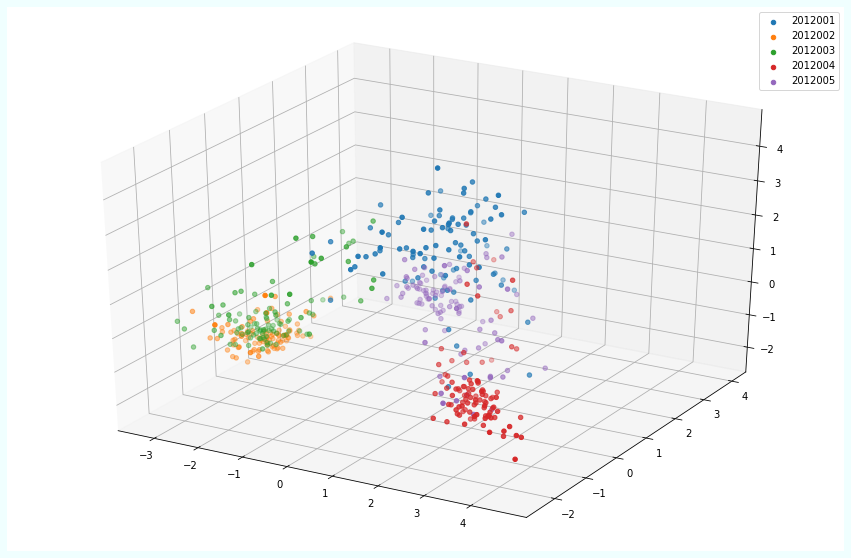

In [14]:
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.metrics import f1_score
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

fig = plt.figure(figsize=(15, 10), facecolor="azure")

ax = fig.gca(projection='3d')
for label in np.unique(labels):
    tmp = nh_pca[np.where(labels==label)[0]]
    ax.scatter(tmp[:, 0], tmp[:, 1], tmp[:, 2], label=label)

plt.legend()
plt.show()

In [15]:
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "vscode"

import numpy as np
data = []
for idx, label in enumerate(np.unique(labels)[:]):
    tmp = nh_pca[np.where(labels == label)[0]]
    data.append(go.Scatter3d(x=tmp[:, 0], y=tmp[:, 1], z=tmp[:, 2], mode='markers', marker=dict(size=2), name=str(label)))
fig = go.Figure(data=data)
fig.update_layout(
    autosize=False,
    width=1000,
    height=1000,
    )
fig.show()